In [79]:
#Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn import preprocessing
from numpy import random
import scipy as sc

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings("always")

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
# import redes neuronales artificiales
from sklearn.neural_network import MLPClassifier
# import random forest
from sklearn.ensemble import RandomForestClassifier
# import maquinas de soporte vectorial
from sklearn.svm import SVC

## Análisis exploratorio de datos 

In [80]:
head_names = ['age', 'job', 'marital', 'education', 'credit', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']
df_bank = pd.read_csv('bank-full.csv', delimiter=';', header=None,names=head_names,skiprows=1)
#df_bank = pd.read_csv('bank.csv', delimiter=';', header=None,names=head_names,skiprows=1)
print("Dimensión data set",df_bank.shape)
df_bank.head()

Dimensión data set (45211, 17)


,age,job,marital,education,credit,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [81]:
y = df_bank["y"]
y = y.replace("no", 0)
y = y.replace("yes", 1)
X = df_bank.drop('y', axis=1)


## Carácteristicas categóricas

En este caso se debe preprocesar aquellas carácteristicas categorical que el modelo no puede entender y convertirlas a variables númericas, a esto se le conoce como *"One Hot Encode"*. Se resuelve con la librería de sklearn o con pandas creando las variables ficticias conocidas **"Dummy variables"**.

Se debe tener en cuenta que podemos eliminar uno variable "dummy" porque si el resto de variables no son debe ser esa, esto quitará redundancia.

Este caso corresponde a las carácteristicas job,education,contact,month y las variables binarias como default, housing,loan, contact y  y.

In [82]:
df_bank.dtypes

age           int64
job          object
marital      object
education    object
credit       object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Se selecciona las variables tipo 'object', en este caso corresponde a variables categoricas. Esto nos permite separar dichas variables para su tratamiento con el "One Hot Encoding" segmentada. 

En la siguiente celda se observa que la variable mes puede ser reemplazado por un valor númerico directamente y así mismo con las variables binarias, a esto se le conoce como "Integer encoding"

In [83]:
obj_df = df_bank.select_dtypes(include=['object']).copy()
obj_df.columns

for column in obj_df.columns:
    print(obj_df[column].value_counts(ascending=True))

unknown           288
student           938
housemaid        1240
unemployed       1303
entrepreneur     1487
self-employed    1579
retired          2264
services         4154
admin.           5171
technician       7597
management       9458
blue-collar      9732
Name: job, dtype: int64
divorced     5207
single      12790
married     27214
Name: marital, dtype: int64
unknown       1857
primary       6851
tertiary     13301
secondary    23202
Name: education, dtype: int64
yes      815
no     44396
Name: credit, dtype: int64
no     20081
yes    25130
Name: housing, dtype: int64
yes     7244
no     37967
Name: loan, dtype: int64
telephone     2906
unknown      13020
cellular     29285
Name: contact, dtype: int64
dec      214
mar      477
sep      579
oct      738
jan     1403
feb     2649
apr     2932
nov     3970
jun     5341
aug     6247
jul     6895
may    13766
Name: month, dtype: int64
success     1511
other       1840
failure     4901
unknown    36959
Name: poutcome, dtype: int64
ye

In [84]:
# Reemplazar el mes y variables binarias por un valor numerico
cat_var = {'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12},
          'housing': {'yes':1,'no':0},
          'credit':{'yes':1,'no':0},
          'loan' : {'yes':1,'no':0},
          'y':{'yes':1,'no':0}
         }
obj_df.replace(cat_var, inplace=True)

#for i in range(df_bank.shape[0]):
#    df_bank.at[i, 'month'] = months[df_bank.at[i, 'month']]

In [85]:
obj_df.head()

,job,marital,education,credit,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,0,1,0,unknown,5,unknown,0
1,technician,single,secondary,0,1,0,unknown,5,unknown,0
2,entrepreneur,married,secondary,0,1,1,unknown,5,unknown,0
3,blue-collar,married,unknown,0,1,0,unknown,5,unknown,0
4,unknown,single,unknown,0,0,0,unknown,5,unknown,0


### One hot Encode job

Ahora bien, aún nos falta 5 variables por aplicar los valores númericos con más de 2 categorías. Tenemos 'job' con 12 categorías, 'marital' con 3, 'education' con 4, 'contact' con 3, por último 'poutcome' con 4.

Hay que tener en cuenta que existe una trampa de la variables ficticias creadas y consiste en crear una nueva variable por cada una, llega a ser redundante. Por tanto la solución está eliminar una de las variables categóricas, si hay $d$ número de categorías, use $d-1$ en el modelo, el valor omitido se puede considerar como el valor de referencia y los valores nuevos de las categorías restantes representan el cambio de esta referencia.

Dicho lo anterior se resta una categoría a cada variable y las otras 5 variables de categorías enteras esperamos 26 variables, el DataFrame resultante se guarda en **obj_df**

In [32]:
cols_dummies = ['job', 'marital', 'education', 'contact', 'poutcome']
obj_df = pd.get_dummies(obj_df,prefix=cols_dummies, drop_first=True)
len(obj_df.columns)

26

In [33]:
#Nombre de las variables categoricas
cat_vars = cols_dummies + list(cat_var.keys())

Nos disponemos a concatenar las variables tipo enteras con las categóricas.

In [34]:
index = ['age','housing', 'loan', 'job_blue-collar','job_entrepreneur', 'job_housemaid', 'job_management', 
         'job_retired','job_self-employed', 'job_services', 'job_student', 'job_technician','job_unemployed',
         'job_unknown', 'marital_married', 'marital_single','education_secondary', 'education_tertiary', 
         'education_unknown','day', 'month','contact_telephone', 'contact_unknown',  'balance',  'duration', 
         'campaign', 'pdays', 'previous','credit','poutcome_other','poutcome_success', 'poutcome_unknown', 'y']

df_bank_copy = df_bank.copy()
df_bank_copy = df_bank_copy.drop(columns=cat_vars)
df_bank_copy.head()
df_bank_2 = pd.concat([obj_df.T, df_bank_copy.T]).T
df_bank_2 = df_bank_2[index]
X = df_bank_2[index]
y = df_bank_2['y']

## Missing data

En nuestro análisis exploratorio, debemos lidiar con los valores faltantes. Al parecer en nuestro caso no hay, sin embargo muchas veces esos valores pueden de diferente formas tales como 0, signos de interrogación o números negativos (según su interpretación). Es así que decidimos ir más allá.

In [35]:
X.info()
X.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 33 columns):
age                    45211 non-null int64
housing                45211 non-null int64
loan                   45211 non-null int64
job_blue-collar        45211 non-null int64
job_entrepreneur       45211 non-null int64
job_housemaid          45211 non-null int64
job_management         45211 non-null int64
job_retired            45211 non-null int64
job_self-employed      45211 non-null int64
job_services           45211 non-null int64
job_student            45211 non-null int64
job_technician         45211 non-null int64
job_unemployed         45211 non-null int64
job_unknown            45211 non-null int64
marital_married        45211 non-null int64
marital_single         45211 non-null int64
education_secondary    45211 non-null int64
education_tertiary     45211 non-null int64
education_unknown      45211 non-null int64
day                    45211 non-null int64
month      

age                    0
housing                0
loan                   0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_married        0
marital_single         0
education_secondary    0
education_tertiary     0
education_unknown      0
day                    0
month                  0
contact_telephone      0
contact_unknown        0
balance                0
duration               0
campaign               0
pdays                  0
previous               0
credit                 0
poutcome_other         0
poutcome_success       0
poutcome_unknown       0
y                      0
dtype: int64

## Imbalanced Classes 

Una vez ya tenemos las variables categoricas listas para entrenar, surge otra cuestión. Contamos con un dataset desbalanceado, la clase positiva (el usuario que se suscribió a la campaña) representa un 13% en comparación de la clase negativa. 

Como primera instancia, vamos a aplicar la técnica de SMOTE para hacer pruebas sintenticas y tratar de mejorar ese porcentaje. No buscamos igualarlo pero si mejorar la situación de desbalanceo al menos un poco.

0    39922
1     5289
Name: y, dtype: int64

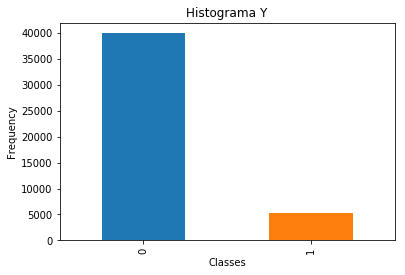

In [78]:
pd.value_counts(y).plot.bar()
plt.title('Histograma Y')
plt.xlabel('Classes')
plt.ylabel('Frequency')
y.value_counts()


In [77]:
index = ['age','housing', 'loan', 'job_blue-collar','job_entrepreneur', 'job_housemaid', 'job_management', 
         'job_retired','job_self-employed', 'job_services', 'job_student', 'job_technician','job_unemployed',
         'job_unknown', 'marital_married', 'marital_single','education_secondary', 'education_tertiary', 
         'education_unknown','day', 'month','contact_telephone', 'contact_unknown',  'balance',  'duration', 
         'campaign', 'pdays', 'previous','credit','poutcome_other','poutcome_success', 'poutcome_unknown']



X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# print("Number transactions X_train dataset: ", X_train.shape)
# print("Number transactions y_train dataset: ", y_train.shape)
# print("Number transactions X_test dataset: ", X_val.shape)
# print("Number transactions y_test dataset: ", y_val.shape)

ValueError: Found input variables with inconsistent numbers of samples: [37052, 45211]

In [38]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy=0.16,random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

X = X_train_res
Y = y_train_res

Before OverSampling, counts of label '1': 4226
Before OverSampling, counts of label '0': 31942 

After OverSampling, the shape of train_X: (37052, 33)
After OverSampling, the shape of train_y: (37052,) 

After OverSampling, counts of label '1': 5110
After OverSampling, counts of label '0': 31942


In [39]:
from sklearn.metrics import recall_score
def measure_train(classifier):
    
    cv_results = pd.DataFrame(classifier.cv_results_)[['param_n_neighbors', 'mean_train_score','std_train_score','mean_test_score','std_test_score','mean_score_time']]
  
    print(cv_results)    
    y_pred = classifier.predict(X_train)
    matrix = confusion_matrix(y_train, y_pred)    
   # print('Recall manual'+ str(recall(matrix)))
    #print('Recall auto '+ str(recall_score(y_train, y_pred)))
    error = ErrorClass(y_train, y_pred) 
    print('Error de entrenamiento = ' + str(error))
    print('Mejor parámetro: '+str(classifier.best_params_))
    
def measure_val(classifier):
    
    y_pred = classifier.predict(X_val)
    print (confusion_matrix(y_val, y_pred))
    error = ErrorClass(y_val,y_pred) 
    print('Error de evaluación final = ' + str(error))

def measure_scoring(classifier):
    cv_results = pd.DataFrame(classifier.cv_results_)[['param_n_neighbors','mean_test_Error','mean_test_AUC','mean_train_Error','mean_train_AUC']]
    y_pred = classifier.predict(X_train)
    error = ErrorClass(y_train, y_pred) 
    print('Error de entrenamiento = ' + str(error))
    print(cv_results)

def measure_val_scoring(classifier):
    
    params = classifier.best_params_
    score = classifier.best_score_
    print ('\n Mejor parámetro '+str(params) + ' mejor valor:'+str(score))
    y_pred = classifier.predict(X_val)
    error = ErrorClass(y_pred,y_val) 
    print('Error de evaluación final = ' + str(error))
    
    
    #Para calcular el error en los problemas de clasificación
def ErrorClass(Y,Y_lest):
    error = 1 - np.sum(Y_lest == Y)/len(Y)    
    return error

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def recall(matrix):
    return (matrix[0,0]/(matrix[0,0]+matrix(1,0)))

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}


## Naïve Bayes

In [40]:
def naiveBayes(X, Y, cv=4, scoring=make_scorer(ErrorClass), refit='AUC'):
    
    parameters = {}
    
    scaler = preprocessing.StandardScaler().fit(X)
    X_norm = scaler.transform(X)
    # creamos el clasificador
    gnb = GaussianNB()
    classifier = GridSearchCV(gnb, parameters, cv=cv, scoring=scoring, refit=refit)
    classifier.fit(X_norm, Y)
    
    return classifier

def naiveBayes2(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train,y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred, y_pred_prob

def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

## K vecinos más cercanos

In [41]:
def kNN(neighbors=1):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    Error = np.zeros(Folds)
    Error_eval = np.zeros(Folds)
    j = 0
   
    
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)
        
        #Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        # creamos el clasificador
        classifier = KNeighborsClassifier(n_neighbors=neighbors)  
        classifier.fit(Xtrain, Ytrain)
        
        y_est = classifier.predict(Xtrain)
        
        y_pred = classifier.predict(Xtest)
        
        y_val_pred = classifier.predict(X_val)
        
        Error_eval[j] = ErrorClass(y_val_pred, y_val)
        
        Error[j] = ErrorClass(y_pred,Ytest)
        
        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(y_est.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(y_pred.ravel() == Ytest.ravel())
        j += 1
        
       
              
    print('Número vecinos: '+ str(neighbors))    
    print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
    print('Error durante la validación = ' + str(np.mean(Error)) + '+-' + str(np.std(Error)))
    print('Error de evalución final = ' + str(np.mean(Error_eval)) + '+-' + str(np.std(Error_eval)))

In [42]:
def KNN(X, Y, neighbors=[5,10], cv=4, scoring=make_scorer(ErrorClass), refit='AUC'):
    
    parameters = {
    'n_neighbors': neighbors}
    
    scaler = preprocessing.StandardScaler().fit(X)
    X_norm = scaler.transform(X)
    # creamos el clasificador
    knn = KNeighborsClassifier()
    classifier = GridSearchCV(knn, parameters, cv=cv, scoring=scoring, refit=refit)
    classifier.fit(X_norm, Y)
    
    return classifier
  

In [43]:
def train_KNN(X, Y, neighbors=[5,10], cv=4):
    
    parameters = {
    'n_neighbors': neighbors}
    
    scaler = preprocessing.StandardScaler().fit(X)
    X_norm = scaler.transform(X)
    # creamos el clasificador
    knn = KNeighborsClassifier()
    classifier = GridSearchCV(knn, parameters, cv=cv)
    classifier.fit(X_norm, Y)
    
    
    return classifier

## Redes Neuronales Artificiales

In [45]:
#Mean Absolute Percentage Error para los problemas de regresión
def MAPE(Y_est,Y):
    N = np.size(Y)
    mape = np.sum(abs((Y_est.reshape(N,1) - Y.reshape(N,1))/Y.reshape(N,1)))/N
    return mape

def neuralNetwork(hidden=(28,)):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = preprocessing.scale(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        mlp = MLPClassifier(activation='tanh', hidden_layer_sizes=hidden, max_iter=500 )
        mlp.fit(Xtrain,Ytrain)

        #Validación con las muestras de entrenamiento
        Ytrain_pred = mlp.predict(Xtrain)

        #Validación con las muestras de test    
        Yest = mlp.predict(Xtest)

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred == Ytrain)
        EficienciaVal[j] = np.mean(Yest == Ytest)
        j += 1
    
    mean = round(np.mean(EficienciaTrain),5)
    std = round(np.std(EficienciaTrain),5)
    
    meanVal = round(np.mean(EficienciaVal),5)
    stdVal = round(np.std(EficienciaVal),5)
    
    return mean,std,meanVal,stdVal

mean,std,meanVal,stdVal = neuralNetwork()
print('Eficiencia durante el entrenamiento = ' + str(mean) + '+-' + str(std))
print('Eficiencia durante la validación = ' + str(np.mean(meanVal)) + '+-' + str(np.std(stdVal)))

Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.86209+-0.0


## Random Forest

In [70]:
def randomForest(num_tree=5, max_var=None):
    #Validamos el modelo
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        model = RandomForestClassifier(n_estimators = num_tree, max_features = max_var)
        model.fit(X=Xtrain, y=Ytrain)

        #Validación
        Ytrain_pred = model.predict(Xtrain)#Use el modelo previamente entrenado para hacer predicciones con las mismas muestras de entrenamiento
        Yest =  model.predict(Xtest)#Use el modelo previamente entrenado para hacer predicciones con las muestras de test

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1

    mean = round(np.mean(EficienciaTrain),4)
    std = round(np.std(EficienciaTrain),4)
    
    meanVal = round(np.mean(EficienciaVal),4)
    stdVal = round(np.std(EficienciaVal),4)
    
    return (mean, std, meanVal, stdVal)

mean, std, meanVal, stdVal = randomForest(3,5)
print('Eficiencia durante el entrenamiento = ' + str(mean) + ' +- ' + str(std))
print('Eficiencia durante la validación = ' + str(meanVal) + ' +- ' + str(stdVal))

Eficiencia durante el entrenamiento = 1.0 +- 0.0
Eficiencia durante la validación = 0.8621 +- 0.0


## Máquinas de Soporte Vectorial con kernel lineal y con kernel RBF.

In [76]:
# lineal kernel and rbf kernel
def SVM(kernel='linear', c=0.001 ,gamma=0):

    if gamma is 0:
        gamma = 'auto'
        
    #Validamos el modelo
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    percentVectors = np.zeros(Folds)
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:].astype(float)
        Ytrain = Y[train].astype(float)
        Xtest = X[test,:].astype(float)
        Ytest = Y[test].astype(float)

        #Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        modelo = SVC(C= c,kernel=kernel,gamma=gamma,  decision_function_shape='ovo')
        modelo.fit(Xtrain, Ytrain)
        
        #Calculamos el porcentaje de vector de soporte
        percentVectors[j] = (len(modelo.support_vectors_)/len(Xtrain))

        #Validación
        Ytrain_pred = modelo.predict(Xtrain)
        Yest = modelo.predict(Xtest)

        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1

        
    #print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
    #print('% Vectore de soporte = ', modelo.n_support_.sum()/720)
    mean = round(np.mean(EficienciaVal),5)
    std = round(np.std(EficienciaVal),5)
    percent = round(percentVectors.sum()/4, 5)
    return mean,std,percent

mean,std,percent = SVM(kernel='linear',c=1, gamma=0)

print('Eficiencia durante el entrenamiento = ' + str(np.mean(mean)) + '+-' + str(np.std(std)))
#print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))
print('% Vectore de soporte = ', percent)

Eficiencia durante la validación = 1.0+-0.0
Eficiencia durante el entrenamiento = 1.0+-0.0
% Vectore de soporte =  0.00272


## Entrenamiento

In [44]:
X = X_train_res
Y = y_train_res

# kNN(1)

#### Naive Bayes

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
y_pred, y_pred_prob = naiveBayes2(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob)

train-set confusion matrix:
 [[22347    12]
 [    0  3577]]
test-set confusion matrix:
 [[9578    5]
 [   3 1530]]
recall score:  0.9980430528375733
precision score:  0.996742671009772
f1 score:  0.997392438070404
accuracy score:  0.9992803166606693
ROC AUC: 0.999795449364392


In [41]:

neighbors=[1,3,5,10]

#def KNN(X, Y, neighbors=[5,10], cv=4, scoring=make_scorer(ErrorClass)):
skf = StratifiedKFold(n_splits=4, random_state=42)
#kNN()
print('Selección del modelo por eficiencia')
classifier = train_KNN(X,Y,neighbors, skf)

measure_train(classifier)
measure_val(classifier)

Selección del modelo por eficiencia


/Users/alejandro/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/alejandro/py3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


  param_n_neighbors  mean_train_score  std_train_score  mean_test_score  \
0                 1          1.000000         0.000000         0.977957   
1                 3          0.986290         0.001352         0.972043   
2                 5          0.979928         0.001755         0.966398   
3                10          0.963173         0.002117         0.951075   

   std_test_score  mean_score_time  
0        0.007982         0.268955  
1        0.012685         0.148908  
2        0.016239         0.135758  
3        0.019548         0.140157  
Error de entrenamiento = 0.11559734513274333
Mejor parámetro: {'n_neighbors': 1}
[[791   2]
 [112   0]]
Error de evaluación final = 0.12596685082872927


/Users/alejandro/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alejandro/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alejandro/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alejandro/py3/lib/python3.7/si

In [ ]:
print('La selección del modelo con AUC \n')
scoring = {'AUC': 'roc_auc', 'Error': make_scorer(ErrorClass)}
classifier_2 = KNN(X,Y, neighbors, skf, scoring, 'AUC')
measure_scoring(classifier_2)
measure_val_scoring(classifier_2)

In [215]:
def trainModel():
    
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

### Tener en cuenta

In [63]:
df_bank['job'].describe()

count           4521
unique            12
top       management
freq             969
Name: job, dtype: object

In [73]:
df_bank[df_bank['pdays'] == -1].shape

(36954, 17)

In [ ]:
out = df_bank["y"]
out = out.replace("no", 0)
out = out.replace("yes", 1)
x = df_bank["education"]
y = df_bank["job"]

#_ = sns.swarmplot(x='duration', y='age', data=df_bank)
#plt.hist(y)
# Label the axes
plt.title('Age vs housing', fontsize=14)
plt.xlabel('Edad')
plt.ylabel('duration')
plt.scatter(x,y,c=out,cmap="Accent")
plt.show()

In [ ]:
sns.set(style="whitegrid")
ax = sns.swarmplot(x="housing", y="age", data=df_bank)

In [34]:

#print("Tipos datos", df_bank.dtypes)
df_bank[df_bank['poutcome'] != 'unknown']
df_success = df_bank[df_bank['y'] == 'yes']
df_no_success = df_bank[df_bank['y'] == 'no']

print("Muestras de exito ",df_success.shape, "Muestras de no éxito",df_no_success.shape)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

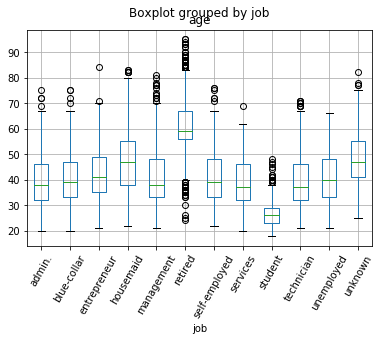

In [17]:
df_bank.boxplot('age','job',rot=60)
plt.show()